<a href="https://colab.research.google.com/github/rama96/hugging-face/blob/master/2_using_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 32.0 MB/s 
     |████████████████████████████████| 120 kB 91.6 MB/s 
     |████████████████████████████████| 6.6 MB 54.4 MB/s 


In [2]:
from transformers import pipeline


## 1. Tokenization step
Raw text - > <br> Tokens -> <br> Special Tokens -> <br> Input IDs


<br><br>

[This course is amazing !] - > <br>
[this , course , is , amazing , ! ] - > <br>
[[CLS], this , course , is , amazing , ! , [SEP]] -> <br>
[ 1, 132 , 123 , 23 ,44, 55]

In [6]:
from transformers import AutoTokenizer
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"

# Most common method
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

raw_inputs = ['This is an example of how tokenizer works',
              'Magnus Carlsen is the best chess player in the world']
inputs = tokenizer(raw_inputs ,
                   padding = True , 
                   truncation = True , # Any input sentence with more than max_length is truncated
                   return_tensors='pt' # To return PyTorch tensors
                   )
print(inputs)

{'input_ids': tensor([[  101,  2023,  2003,  2019,  2742,  1997,  2129, 19204, 17629,  2573,
           102,     0,     0],
        [  101, 10045,  5529,  5054,  2003,  1996,  2190,  7433,  2447,  1999,
          1996,  2088,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


##2. Going through the model 

### 2.1 Automodel

In [9]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

# it downloads and caches the configuration of the model as well as the pretrained weights . 
# It only instantiates the body of the model with pre-trained head is removed. 

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 13, 768])


2 => BatchSize (Because of 2 input examples ) <br>
13 => Length of the numerical representation of the sequence <br>
768 => Hidden size , Larger models have larger hidden size values <br>

### 2.2 AutoModelForSequenceClassification

AutoModelForXxx class loads the model for a specific task . In this case , it's exactly like an Automodel but with a classification head

*Model (retrieve the hidden states) <br>
*ForCausalLM <br>
*ForMaskedLM <br>
*ForMultipleChoice<br>
*ForQuestionAnswering<br>
*ForSequenceClassification<br>
*ForTokenClassification<br>
and others 🤗<br>

In [10]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

output = model(**inputs)
print(output.logits)

tensor([[-3.1381,  3.2573],
        [-4.2419,  4.5853]], grad_fn=<AddmmBackward0>)


These are logits and are not output from activations. So to convert these into probabilities apply Softmax 


## 3. PostProcessing

In [12]:
import torch

predictions = torch.nn.functional.softmax(output.logits, dim = -1)
print(predictions)


tensor([[1.6664e-03, 9.9833e-01],
        [1.4668e-04, 9.9985e-01]], grad_fn=<SoftmaxBackward0>)


In [14]:
model.config.id2label
# Helps to understand the prediction labels 1
# in this case , both are classified as positive statements 

{0: 'NEGATIVE', 1: 'POSITIVE'}

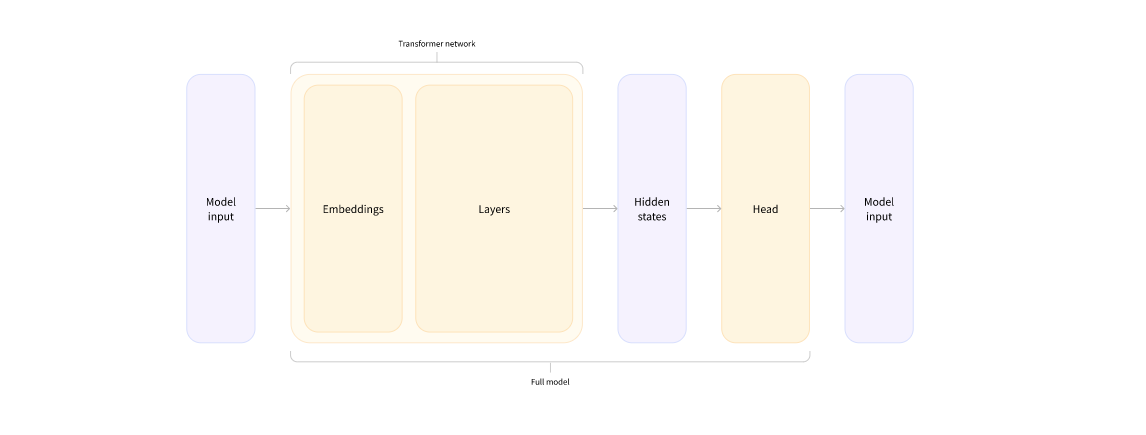

In [21]:
from transformers import AutoModelForMaskedLM ,AutoTokenizer

checkpoint = "distilroberta-base"
model = AutoModelForMaskedLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


raw_inputs = ['My <mask> is Rama',
              'I work at <mask>']
inputs = tokenizer(raw_inputs ,
                   padding = True , 
                   truncation = True , # Any input sentence with more than max_length is truncated
                   return_tensors='pt' # To return PyTorch tensors
                   )

# inputs
output = model(**inputs)
print(output.logits)

tensor([[[ 34.7359,  -4.8791,  21.2362,  ...,   0.4934,   3.5516,  13.2017],
         [  5.5378,  -5.3562,  16.0790,  ...,  -2.3625,   0.4682,   2.9870],
         [ -5.3150,  -5.3309,   2.3016,  ...,  -7.9356,  -5.4794,  -2.4606],
         ...,
         [ -1.5306,  -6.2953,   8.4770,  ...,  -5.4117,  -4.1099,  -1.4207],
         [ -0.9039,  -6.0516,   8.3035,  ...,  -8.0381,  -5.9725,   0.1581],
         [ 14.6255,  -6.6488,  22.1655,  ...,  -3.9008,  -1.4958,   4.5869]],

        [[ 34.9247,  -4.7844,  20.9546,  ...,   0.6829,   3.0318,  13.2775],
         [  4.8749,  -5.2076,  13.2881,  ...,  -4.9349,  -3.9482,   1.8015],
         [ -3.3881,  -5.9698,   9.7989,  ...,  -3.5722,  -3.4903,  -3.1264],
         ...,
         [ -4.3650,  -6.1633,   5.9955,  ...,  -9.7195, -10.1738,  -0.3317],
         [ 14.9038,  -6.5304,  21.5897,  ...,  -3.9242,  -2.2425,   4.7664],
         [  1.1676,  -5.0391,  10.4798,  ...,  -6.3138,  -6.3604,   1.6753]]],
       grad_fn=<ViewBackward0>)


In [22]:
print(output.logits.shape)

torch.Size([2, 7, 50265])


In [28]:
## Open Point -  How to create the same for AutoModelForMaskedLM ? 